# 3.2 tf.GradientTapeクラスで回帰問題を解く

## 線形回帰分析による未知の値の予測

「ネット広告 (cost) 」と「売上額 (sales) 」のデータ
<a href="../local/sample/chap03/03_02/sales.csv">sales.csv</a>

In [1]:
# csvデータをファイルからロードする
import numpy as np
import os

DIR="../local/sample/chap03/03_02/"
data_path = os.path.join(DIR, 'sales.csv')

data =  np.loadtxt(fname=data_path,
                   dtype='int', 
                   delimiter=',',
                   skiprows=1     # 1行目はタイトルなので読み飛ばす
                  )
train_x = data[:, 0]   # cost
train_y = data[:, 1]   #sales

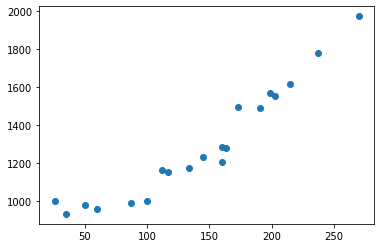

In [2]:
# グラフを描く
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(train_x, train_y, 'o')

plt.show()

## 線形回帰分析の勾配降下アルゴリズムを tf.GradientType で実装する

### データの標準化
平均(mean)=0, 標準偏差(standard deviation)=1とする。

In [3]:
# s-02-3
def standardize(x):
    x_mean = x.mean()
    std = x.std()
    return (x - x_mean) / std

In [4]:
# 3-02-4

train_x_std = standardize(train_x)
train_y_std = standardize(train_y)

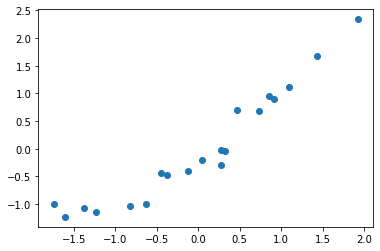

In [5]:
# グラフにプロットする
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(train_x_std, train_y_std, 'o')

plt.show()

In [6]:
# 3-02-05 Variableオブジェクトを用意する
import tensorflow as tf

a = tf.Variable(0.)
b = tf.Variable(0.)

In [7]:
# 3-02-06 線形回帰モデルの定義
def model(x):
    '''
    回帰モデル y = ax+b
    '''
    y = a * x + b
    return y

In [8]:
# 3-02-07 損失関数の定義
def loss(y_pred, y_true):
    '''
    Mean Squared Errors 平均2乗誤差
    '''
    return tf.math.reduce_mean(tf.square(y_pred - y_true))

## 勾配降下アルゴリズムの実装

### tf.GradientTape()

<code>tf.GradientTape([persistent=False, watch_accessed_variables=True])</code>

TensorFlow の公式ガイドで、GradientTape オブジェクトの生成から計算式の登録まで with ブロックでまとめることが推奨されている。
as で指定するオブジェクト変数は、定義後であればwithブロックの外部からでもアクセスできる。

#### persistent

永続的なテープ (記録する仕組み)を作成するかどうかを指定する(default: False)。
複数の勾配を計算する場合は True を指定して、gradient()メソッドを複数回呼べるようにする。

#### watch_accessed_variables

変数をトレーニング(更新)可能とするかどうか(default: True)。

### grdient()

<code>gradient(
    target, 
    sources[,
    output_gradients=None, 
    unconnected_gradients=tf.UnconnectedGradients.NONE]
)</code>

GradientTape オブジェクトに記録された操作を使って、勾配を計算する。

#### target
勾配計算に用いるテンソルまたは変数のリスト。損失関数を指定する。

#### sources
入力するテンソルオブジェクト。この入力テンソルに対する target の微分が求められる。

In [9]:
# GradientTape を利用した勾配計算の例

x = tf.Variable(3.0)  # 変数を作成する
with tf.GradientTape() as g:
    g.watch(x)   # 省略可能
    y = x * x

grad = g.gradient(y, x) # dy/dx を計算する
print(grad.numpy())

6.0


In [10]:
# 3-02-08 Gradient Descent による最適化処理の実装
learning_rate = 0.1
epochs = 50

for i in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = model(train_x_std)
        tmp_loss = loss(y_pred, train_y_std)
    gradients = tape.gradient(tmp_loss, [a,b]) # 変数a,bに対する tmp_lossの勾配
    a.assign_sub(learning_rate * gradients[0])
    b.assign_sub(learning_rate * gradients[1])
    
    if (i+1)%5 == 0:
        print(f'Step: {(i+1)} a={a.value():.6f} b={b.value():.6f} Loss={tmp_loss:.6f}')

Step: 5 a=0.639235 b=-0.000000 Loss=0.247664
Step: 10 a=0.848700 b=-0.000000 Loss=0.112283
Step: 15 a=0.917337 b=-0.000000 Loss=0.097746
Step: 20 a=0.939828 b=-0.000000 Loss=0.096186
Step: 25 a=0.947198 b=-0.000000 Loss=0.096018
Step: 30 a=0.949613 b=-0.000000 Loss=0.096000
Step: 35 a=0.950405 b=-0.000000 Loss=0.095998
Step: 40 a=0.950664 b=-0.000000 Loss=0.095998
Step: 45 a=0.950749 b=-0.000000 Loss=0.095998
Step: 50 a=0.950777 b=-0.000000 Loss=0.095998


### tf.Variable.assign_sub()
変数(Variable) から指定した値を減算する。

<code>assign_sub(
    delta [,
    use_locking=False,
    name=None,
    read_value=True
    ])</code>

<pre>
    delta: (Tensor オブジェクト) 変数から減算する値。
    use_locking: (Boolean) 操作中にlockするか否か
    name: 作成する操作名
    read_value: (Boolean) Trueだと「変数の新しい値」が、Falseだと「操作」が返される
</pre>

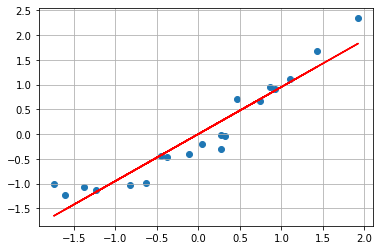

In [12]:
# 3-02-9 グラフの描画
%matplotlib inline
import matplotlib.pyplot as plt

final_a = a.value()
final_b = b.value()

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(train_x_std, train_y_std)

y_learned = final_a * train_x_std + final_b
ax.plot(train_x_std, y_learned,c='r')

ax.grid()
plt.show()

In [14]:
# 3-02-10 予測する
input_x = input('予測に使用するxの値を入力してください >')
x_mean = train_x.mean() # 平均
std = train_x.std()     # 標準偏差
x = (int(input_x) - x_mean) / std    # 入力値を標準化

y = (final_a * x + final_b).numpy()
y_mean = train_y.mean()    # yの平均値
y_std = train_y.std()      # yの標準偏差

y_org = y * y_std + y_mean
print(y_org)

予測に使用するxの値を入力してください >300
1947.2206607488235
